In [1]:
import numpy as np
from einops import rearrange

from utils import *

from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

import os

In [3]:
# HARDCODED FOR LLAVA
num_heads = 40
num_layers = 40

base_dir = 'vgr_probing/features_attack'

In [4]:
def get_head_values_matrix():
    # feature_dir_all = [os.path.join(base_dir, f) for f in os.listdir(base_dir)]
    head_wise_activations_all = []
    head_matrix_files = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if 'head' in f]
    for filepath in head_matrix_files:
        head_wise_activations = np.load(filepath)
        head_wise_activations = rearrange(head_wise_activations, 'b l (h d) -> b l h d', h = num_heads)
        head_wise_activations_all.append(head_wise_activations)
    head_wise_activations_all = np.stack(head_wise_activations_all)
    return head_wise_activations_all

In [5]:
def get_head_similarity_dict(head_value_matrix):
    head_sim_dict = {f'l{l}_h{h}': [] for l in range(num_layers) for h in range(num_heads)} 
    # ^ each dict value with be an array of length #n_question
    for q_idx in tqdm(range(head_value_matrix.shape[1])):
        q_head_vals = head_value_matrix[:, q_idx, :, :, :]
        for l in range(num_layers):
            for h in range(num_heads):
                vectors = q_head_vals[:, l, h, :]
                cosine_sim = cosine_similarity(vectors)
                pairwise_sim = cosine_sim[0,1]
                avg_sim = np.mean(pairwise_sim) #taking mean across permutations
                head_sim_dict[f'l{l}_h{h}'].append(avg_sim)
    return head_sim_dict

In [7]:
head_matrix = get_head_values_matrix()
head_sim_dict = get_head_similarity_dict(head_matrix)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:43<00:00,  3.06it/s]


mean 0.600817792548908 0.999999494140524


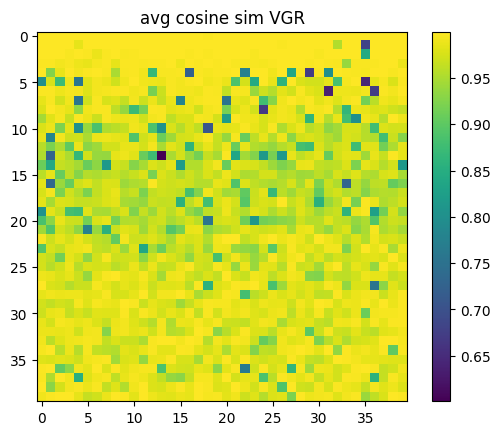

In [9]:
# fig, axs = plt.subplots(1,len(head_sim_dict_all), figsize=(15,8))
# for i, key in enumerate(head_sim_dict_all):
#     head_sim_dict = head_sim_dict_all[i]
mean_sim_noption = [np.mean(head_sim_dict[key]) for key in list(head_sim_dict.keys())] #taking mean across questions
l_h_sim_avg = np.array(mean_sim_noption).reshape(num_heads, num_layers) # row = heads | colums = layers
print('mean', np.amin(l_h_sim_avg), np.amax(l_h_sim_avg))
plt.imshow(l_h_sim_avg)
plt.title(f'avg cosine sim VGR')
plt.colorbar()
plt.show()

In [ ]:
fig, axs = plt.subplots(2,len(head_sim_dict_all), figsize=(15,8))
for i, key in enumerate(head_sim_dict_all):
    head_sim_dict = head_sim_dict_all[i]
    mean_sim_noption = [np.mean(head_sim_dict[key]) for key in list(head_sim_dict.keys())]
    l_h_sim_avg = np.array(mean_sim_noption).reshape(num_heads, num_layers) # row = heads | colums = layers
    l_h_sim_avg.sort(axis=1)
    im0 = axs[0, i].imshow(l_h_sim_avg)
    axs[0,i].set_title(f'SORTED avg cosine sim {n_options_all[i]}')
    
    std_sim_noption = [np.std(head_sim_dict[key]) for key in list(head_sim_dict.keys())]
    l_h_sim_std = np.array(std_sim_noption).reshape(num_heads, num_layers) # row = heads | colums = layers
    l_h_sim_std.sort(axis=1)
    axs[1,i].set_title(f'SORTED std cosine sim {n_options_all[i]}')
    im1 = axs[1, i].imshow(l_h_sim_std)
plt.show()